# preparations for the optimization

From the temperature differences, we can compute:
- the emission probability matrix
- the initial probability
- the final probability
- the ocean mask
- the maximum sigma

In [1]:
import pint_xarray
import xarray as xr

In [2]:
from pangeo_fish.distributions import create_covariances, normal_at
from pangeo_fish.pdf import normal
from pangeo_fish.utils import temporal_resolution

parameters

In [3]:
scheduler_address: str | None = None

differences_path: str
tag_path: str

diff_std: float = 0.75
recapture_std: float = 1e-2

truncate: float = 4.0

output_path: str

In [4]:
tag_url: str

catalog: str
catalog_parameters: dict = {}

scheduler_address: str | None = None

relative_depth_threshold: float = 0.8

diff_path: str

# local PC
tag_url="/Users/todaka/python/git/pangeo-fish/data_local/fish-intel/tag/nc/A18832.nc"
catalog = "https://data-taos.ifremer.fr/kerchunk/ref-copernicus.yaml"
scheduler_address: str | None = None
catalog = "https://data-taos.ifremer.fr/kerchunk/ref-marc.yaml"
diff_path="/Users/todaka/python/git/pangeo-fish/data_local/fish-intel/A18832-f1_e2500/diff.zarr"
# mars
catalog = "/home/datawork-taos-s/intranet/kerchunk/ref-marc.yaml"
catalog_parameters: dict = {  "region": "f1_e2500",  "year": "2022"}
diff_path="/home/datawork-taos-s/public/fish/A18832-f1_e2500/diff.zarr"
diff_healpix_path="/home/datawork-taos-s/public/fish/A18832-f1_e2500/diff_healpix.zarr"

# Datarmor
tag_url="/home/datawork-lops-iaocea/data/fish-intel/tag/nc/A18832.nc"
# copernicus
catalog="/home/datawork-taos-s/intranet/kerchunk/ref-copernicus.yaml"
#catalog_parameters: dict = {  "type": ["2022_3D","2022_2D","mdt"]}
diff_path="/home/datawork-taos-s/public/fish/A18832-copernicus/diff.zarr"
diff_healpix_path="/home/datawork-taos-s/public/fish/A18832-copernicus/diff_healpix.zarr"
emission_path="/home/datawork-taos-s/public/fish/A18832-copernicus/emission.zarr"






In [5]:
import dask_hpcconfig
from distributed import Client

In [6]:
cluster = dask_hpcconfig.cluster("datarmor-local")
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42435,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 120.00 GiB
Comm: tcp://127.0.0.1:35315,Total threads: 7
Dashboard: http://127.0.0.1:58821/status,Memory: 15.00 GiB
Nanny: tcp://127.0.0.1:52672,


dask cluster

## open the data

In [7]:
tag = xr.open_dataset(tag_url, engine="netcdf4")
tag

/home1/datawork/todaka/micromamba/pangeo-fish-iaocea/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


<xarray.Dataset>
Dimensions:            (deployments: 1, timestamp: 7, mission_day: 81,
                        time: 77152, events: 3)
Coordinates:
  * deployments        (deployments) int64 0
  * timestamp          (timestamp) object '03/03/2022 10:55:00' ... '16/06/20...
  * mission_day        (mission_day) int64 0 1 2 3 4 5 6 ... 75 76 77 78 79 80
  * time               (time) datetime64[ns] 2022-06-17 ... 2022-09-05T08:46:30
  * events             (events) object 'release' 'recapture' 'tag_recovery'
    latitude           (events) float64 ...
    longitude          (events) float64 ...
    times              (events) datetime64[ns] ...
Data variables: (12/19)
    start              (deployments) object ...
    stop               (deployments) object ...
    logging_rate       (deployments) int64 ...
    sensors            (deployments) object ...
    resolution         (deployments) int64 ...
    fast_rate          (deployments) object ...
    ...                 ...
    min_temp           (mission_day) float64 ...
    max_depth          (mission_day) float64 ...
    min_depth          (mission_day) float64 ...
    batt_volts         (mission_day) float64 ...
    pressure           (time) float64 ...
    water_temperature  (time) float64 ...
Attributes: (12/14)
    firmware_version_no:          3
    firmware_build_level:         80
    tag_id:                       A18832
    pressure_range:               20
    no_of_sensors:                2
    dive_termination_percentage:  1.5%
    ...                           ...
    start_time:                   17/06/2022 00:00:00
    stop_time:                    08/12/2027
    logging_rate:                 90
    resolution:                   12
    data_points_available:        77152
    block_number:                 0

In [8]:
differences = xr.open_dataset(diff_healpix_path, engine="zarr", chunks={})
differences

<xarray.Dataset>
Dimensions:     (x: 527, y: 466, time: 1814)
Coordinates:
    cell_ids    (x, y) int64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    latitude    (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    longitude   (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    resolution  float64 ...
  * time        (time) datetime64[ns] 2022-06-17T11:00:00 ... 2022-09-01
Dimensions without coordinates: x, y
Data variables:
    H0          (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    diff        (time, x, y) float64 dask.array<chunksize=(1, 527, 466), meta=np.ndarray>
Attributes:
    nside:    4096
    rot_lat:  0
    rot_lon:  30
    tag_id:   A18832

## ocean mask

In [9]:
ocean_mask = differences["H0"].notnull()
ocean_mask

<xarray.DataArray 'H0' (x: 527, y: 466)>
dask.array<invert, shape=(527, 466), dtype=bool, chunksize=(527, 466), chunktype=numpy.ndarray>
Coordinates:
    cell_ids    (x, y) int64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    latitude    (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    longitude   (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    resolution  float64 ...
Dimensions without coordinates: x, y

## emission probability matrix

In [10]:
emission_pdf = normal(
    differences["diff"],
    mean=0,
    std=diff_std,
    dims=["x", "y"],
)
emission_pdf

<xarray.DataArray 'pdf' (time: 1814, x: 527, y: 466)>
dask.array<transpose, shape=(1814, 527, 466), dtype=float64, chunksize=(1, 527, 466), chunktype=numpy.ndarray>
Coordinates:
    cell_ids    (x, y) int64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    latitude    (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    longitude   (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    resolution  float64 ...
  * time        (time) datetime64[ns] 2022-06-17T11:00:00 ... 2022-09-01
Dimensions without coordinates: x, y

## initial and final probability

In [11]:
grid = differences[["latitude", "longitude"]].compute()
grid

<xarray.Dataset>
Dimensions:     (x: 527, y: 466)
Coordinates:
    latitude    (x, y) float64 42.41 42.42 42.44 42.45 ... 54.5 54.51 54.52
    longitude   (x, y) float64 -5.295 -5.282 -5.268 ... -3.084 -3.066 -3.047
    cell_ids    (x, y) int64 9876645 9876647 9876653 ... 13277089 13277091
    resolution  float64 0.0002498
Dimensions without coordinates: x, y
Data variables:
    *empty*
Attributes:
    nside:    4096
    rot_lat:  0
    rot_lon:  30
    tag_id:   A18832

initial

In [12]:
initial_position = tag[["latitude", "longitude", "time"]].sel(events="release")
cov = create_covariances(1e-6, coord_names=["latitude", "longitude"])
initial_probability = normal_at(
    grid, pos=initial_position, cov=cov, normalize=True, axes=["latitude", "longitude"]
)
initial_probability

<xarray.DataArray 'normal_pdf' (x: 527, y: 466)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    latitude   (x, y) float64 42.41 42.42 42.44 42.45 ... 54.48 54.5 54.51 54.52
    longitude  (x, y) float64 -5.295 -5.282 -5.268 ... -3.084 -3.066 -3.047
Dimensions without coordinates: x, y

final

In [13]:
final_position = tag[["longitude", "latitude", "times"]].sel(events="recapture")

cov = create_covariances(recapture_std**2, coord_names=["latitude", "longitude"])
final_probability = normal_at(
    grid, pos=final_position, cov=cov, normalize=True, axes=["latitude", "longitude"]
)

## maximum sigma

In [14]:
earth_radius = xr.DataArray(6371, dims=None).pint.quantify("km")

timedelta = temporal_resolution(differences.time).pint.quantify().pint.to("h")
grid_resolution = earth_radius * differences["resolution"].pint.quantify()

max_speed = xr.DataArray(60, dims=None).pint.quantify("km / day").pint.to("km / h")
# to make the search a bit more fuzzy
adjustment_factor = 10
max_grid_displacement = max_speed * timedelta * adjustment_factor / grid_resolution

max_sigma = max_grid_displacement.pint.to("dimensionless").pint.magnitude / truncate
max_sigma

3.926612558378512

## pull everything together and write to disk

In [15]:
emission = xr.Dataset(
    {
        "pdf": emission_pdf,
        "mask": ocean_mask,
        "initial": initial_probability,
        "final": final_probability,
    },
    attrs=differences.attrs | {"max_sigma": max_sigma},
).chunk()
emission

<xarray.Dataset>
Dimensions:     (x: 527, y: 466, time: 1814)
Coordinates:
    cell_ids    (x, y) int64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    latitude    (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    longitude   (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    resolution  float64 0.0002498
  * time        (time) datetime64[ns] 2022-06-17T11:00:00 ... 2022-09-01
Dimensions without coordinates: x, y
Data variables:
    pdf         (time, x, y) float64 dask.array<chunksize=(1, 527, 466), meta=np.ndarray>
    mask        (x, y) bool dask.array<chunksize=(527, 466), meta=np.ndarray>
    initial     (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    final       (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
Attributes:
    nside:      4096
    rot_lat:    0
    rot_lon:    30
    tag_id:     A18832
    max_sigma:  3.926612558378512

In [16]:
%%time
emission.to_zarr(emission_path, mode="w", consolidated=True, compute=True)

CPU times: user 6.5 s, sys: 148 ms, total: 6.64 s
Wall time: 9.57 s


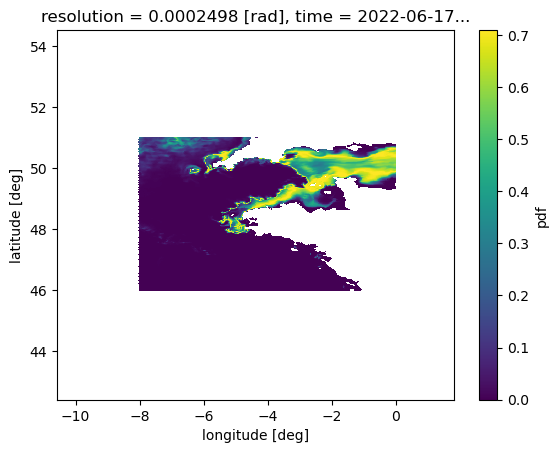

In [18]:
emission_=xr.open_zarr(emission_path)
emission_.pdf.isel(time=0).plot(x='longitude',y='latitude')